In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Reading corpus the text file
with open("/content/dataset_book.txt", 'r', encoding='utf-8-sig') as myfile:
    mytext = myfile.read()

In [ ]:
def expand_contractions(text, model='contractions'):
    """
    Expands contractions in a given text.

    Parameters
    ----------
    text : str
        The text to expand contractions in.
    model : str
        The model to use to expand contractions. Defaults to 'contractions'.
        Options:
            'contractions' - uses the contractions library
            'pycontractions' - uses the pycontractions library. Greater accuracy as it looks at the context of the word. Has frequent dependency issues.

    Returns
    -------
    str
        The text with contractions expanded.
    """

    try:
        if model == 'contractions':
            import contractions
            text = contractions.fix(text)
            return text

        elif model == 'pycontractions':
            import pycontractions

            # Load the contraction model
            cont = pycontractions.Contractions(api_key="glove-twitter-100")
            cont.load_models()

            # Expand contractions in the text
            expanded_text = list(cont.expand_texts([text], precise=True))[0]
            return expanded_text
        else:
            raise Exception(
                f"Model '{model}' is not supported. Please choose either 'contractions' or 'pycontractions'.")
    except Exception as e:
        print(f"Error expanding contractions: {e}")

In [ ]:
def remove_punctuation_and_numbers(text):
    """Removes punctuation and numbers from a given text.

    Parameters
    ----------
    text : str
        The text to remove punctuation and numbers from.

    Returns
    -------
    str
        The text with punctuation and numbers removed.
    """

    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    return text


In [ ]:
def lowercase_and_strip_whitespaces(text):
    """Converts a given text to lowercase and strips multiple whitespaces to a single whitespace.

    Parameters
    ----------
    text : str
        The text to convert.

    Returns
    -------
    str
        The converted text with multiple whitespaces stripped to a single whitespace and converted to lowercase.
    """
    # strip multiple whitespaces
    text = ' '.join(text.split())

    # convert to lower case
    text = text.lower()

    return text

In [ ]:
from posixpath import split

def preprocessing(mytext):
  m = mytext.split('\n\n')
  for i, s in enumerate(m):
    m[i] = s.replace('\n', '')
    m[i] = m[i].replace(u'\xa0',u' ')
    m[i] = m[i].replace('\u200a',' ')
    m[i] = ' '.join(m[i].split())
    m[i] = expand_contractions(m[i])
    m[i] = remove_punctuation_and_numbers(m[i])
    m[i] = lowercase_and_strip_whitespaces(m[i])

  m = [sentence for sentence in m if sentence.strip() != ""]
  m = m[:1000]
  mytokenizer = Tokenizer()
  mytokenizer.fit_on_texts(m)
  word_index = mytokenizer.word_index
  total_words = len(mytokenizer.word_index) + 1

  my_input_sequences = []
  for line in m:
    #print(line)
    token_list = mytokenizer.texts_to_sequences([line])[0]
    # print(token_list)
    for i in range(1, len(token_list)):
        my_n_gram_sequence = token_list[:i+1]
        # print(my_n_gram_sequence)
        my_input_sequences.append(my_n_gram_sequence)
        #print(input_sequences)

  max_sequence_len = max([len(seq) for seq in my_input_sequences])
  input_sequences = np.array(pad_sequences(my_input_sequences, maxlen=max_sequence_len, padding='pre'))
  X = input_sequences[:, :-1]
  Y = input_sequences[:, -1]
  Y = np.array(tf.keras.utils.to_categorical(Y, num_classes=total_words))

  from sklearn.model_selection import train_test_split


  X_train, X_test, y_train, y_test = train_test_split(
      X, Y, test_size=0.1, random_state=56, shuffle=True)
  return m, X_train, X_test, y_train, y_test, total_words, max_sequence_len, word_index, mytokenizer

In [ ]:
m, X_train, X_test, y_train, y_test, total_words, max_sequence_len, word_index, mytokenizer = preprocessing(mytext)

In [ ]:
X_train

array([[   0,    0,    0, ...,   15,  220,  865],
       [   0,    0,    0, ...,   19,    7,  940],
       [   0,    0,    0, ...,    4, 3130,   16],
       ...,
       [   0,    0,    0, ..., 2664,    7,  146],
       [   0,    0,    0, ...,    7,  745,   14],
       [   0,    0,    0, ...,  281,    6,  229]], dtype=int32)

In [ ]:
X_train.shape

(48454, 491)

In [ ]:
print(len(word_index) + 1)

4697


In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model2.add(LSTM(150))
model2.add(Dense(total_words, activation='softmax'))
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 491, 100)          469700    
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 4697)              709247    
                                                                 
Total params: 1329547 (5.07 MB)
Trainable params: 1329547 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model.h5', monitor='accuracy', save_best_only=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'],)
history = model2.fit(X_train, y_train, epochs=70, verbose=1, batch_size=32, callbacks=[checkpoint])

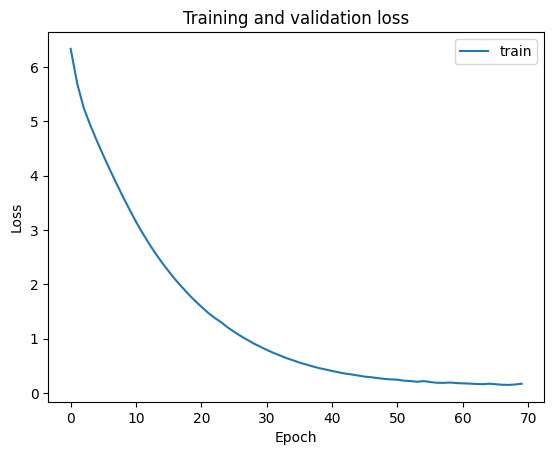

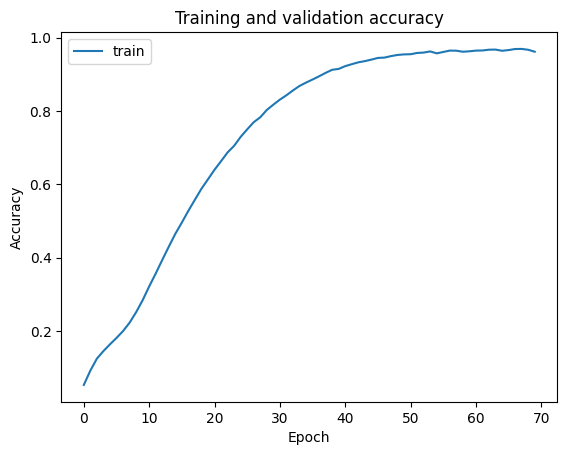

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation loss
plt.plot(history.history['loss'], label='train')

plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model1 = load_model('my_model.h5')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_text = "possession"
top_words_out = []
predict_next_words = 3  # Set to the number of top words you want to predict

for _ in range(predict_next_words):
    token_list = mytokenizer.texts_to_sequences([input_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    predictions = model1.predict(token_list)[0]
    # Get the indices of the top N words
    top_indices = np.argpartition(predictions, -predict_next_words)[-predict_next_words:]

    # Get the words corresponding to the top indices
    top_words = [word for word, index in mytokenizer.word_index.items() if index in top_indices]
    top_probabilities = predictions[top_indices]
    print(top_probabilities)

    # Choose one of the top words randomly or based on some other criteria
    # output_word = np.random.choice(top_words)
    top_words_out = top_words

result = []
for word in top_words_out:
  result.append(str(word))

print(input_text)
print(result)


1/1 [==============================] - 0s 86ms/step
[0.00589708 0.00730192 0.9812572 ]
1/1 [==============================] - 0s 86ms/step
[0.00589708 0.00730192 0.9812572 ]
1/1 [==============================] - 0s 91ms/step
[0.00589708 0.00730192 0.9812572 ]
possession
['of', 'for', 'this']


In [ ]:
input_text = "very"
predict_next_words= 20
# _,_,_,_,_,_,_,_,_,_,mytokenizer = preprocessing(mytext)

for _ in range(predict_next_words):
    token_list = mytokenizer.texts_to_sequences([input_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model1.predict(token_list), axis=-1)
    output_word = ""
    for word, index in mytokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    input_text += " " + output_word

print(input_text)

[32]
1/1 [==============================] - 2s 2s/step
[32, 84]
1/1 [==============================] - 0s 212ms/step
[32, 84, 80]
1/1 [==============================] - 0s 133ms/step
[32, 84, 80, 110]
1/1 [==============================] - 0s 185ms/step
[32, 84, 80, 110, 32]
1/1 [==============================] - 0s 241ms/step
[32, 84, 80, 110, 32, 148]
1/1 [==============================] - 0s 152ms/step
[32, 84, 80, 110, 32, 148, 10]
1/1 [==============================] - 0s 159ms/step
[32, 84, 80, 110, 32, 148, 10, 56]
1/1 [==============================] - 0s 125ms/step
[32, 84, 80, 110, 32, 148, 10, 56, 24]
1/1 [==============================] - 0s 122ms/step
[32, 84, 80, 110, 32, 148, 10, 56, 24, 1]
1/1 [==============================] - 0s 162ms/step
[32, 84, 80, 110, 32, 148, 10, 56, 24, 1, 176]
1/1 [==============================] - 0s 168ms/step
[32, 84, 80, 110, 32, 148, 10, 56, 24, 1, 176, 240]
1/1 [==============================] - 0s 178ms/step
[32, 84, 80, 110, 32, 148, 